# Classification

## MNIST

In this chapter we will be using the MNIST dataset, a set of 70k small images of digits handwritten by HS students and US employees. Each image is labeled with the digit it represents.
This dataset is considered the "Hello world" of Machine Learning.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them.
The following code fetches the MNIST dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version = 1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:

- A DESCR key describing the dataset
- A data key  containing an array with one row per instance and one column per feature
- A target key containing an array with the labels

In [2]:
# let's look at these arrays:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


There are 70k images, and each image has 784 features. This is because each image is 28x28 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). Let's take a peek at one digit from the dataset. All you need to do is to grab an instance's feature vector, reshape it to a 28x28 array, and display it using Matplotlib's imshow() function:

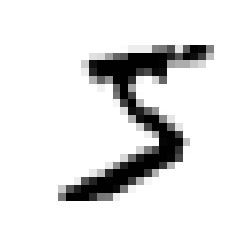

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

This looks like a 5 and indeed that's what the label tells us
Note that the label is a string. We prefer numbers, so let's cast y to ingegers:

In [4]:
import numpy as np
print(y[0])
y = y.astype(np.uint8)

5


But wait! You should always create a ttest set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into training set (the first 60k images) and a test set (the last 10k images):

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar (you don't want one fold to be missing some digits). Moreover, some learning algos are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won't happen.

## Training a Binary Classifier

Let's simplify the problem for now and only try to identify one digit -- for example, the number 5. This "5-detector" will be an example of a *binary classifier* capable of distinguishing between two classes, 5 and NOT 5. Let's create the target vectors for this classification task:

In [6]:
y_train_5 = (y_train == 5)  #Boolean vector, True for 5s, False for all other digits
y_test_5 = (y_test == 5)

Okay, now let's pick a classifier and train it, A good place to start is with a *Stochastic Gradient Descent* (SGD) classifier, using Scikit-Learn's SGDClassifier class.

This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training istances independently, one at a time (which also makes SGD well suited for *online learning*), as we will see later. 

Let's create an SGDClassifier and train it on the whole training set:

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3,random_state = 42)
sgd_clf.fit(X_train, y_train_5)
"""
The SGDClassifier relies on randomness during training (hence the name stochastic). 
If you want reproducible results, you should set the random_state parameter
"""
# Now you can use it to detect images of the number 5:
print(sgd_clf.predict([some_digit]))

[ True]


## Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many peformance measures available.

### Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation.

#### Implementing Cross-Validation
Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off-the-shelf. In these cases, you can implement cross-validation yourself; it is actually fairly straightforward. The following code does roughly the same thing as Scikit-Learn's cross_val_score() function, and prints the same result:

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


skfolds = StratifiedKFold(n_splits = 3, random_state = 42) # nsplits = 3 --> 3fold CV
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # get fresh copy of predictor
    clone_clf = clone(sgd_clf)
    """
    from clone doc
    
    Constructs a new estimator with the same parameters.

    Clone does a deep copy of the model in an estimator without actually copying attached data. 
    It yields a new estimator with the same parameters that has not been fit on any data.
    """
    # set training and testing subset iteration
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    # fit predictor for iteration
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))    

0.96355
0.93795
0.95615


The StratifiedKFold class performs stratified sampling to produce folds that contain representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

Let's use the cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds. Remember that K-fold cross-validation means splitting the training set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds:

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.96355, 0.93795, 0.95615])

Over 93% *accuracy* (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn't it? Well, before you get too excited, let's look at a very dumb classifier that just classifies every single image in the "not-5" class:

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    # do nothing for fit
    def fit(self, X, y = None):
        pass
    # predict everything as false
    def predict(self, X):
        return np.zeros((len(X),1), dtype = bool)
# can you guess this model's accuracy? Let's find out:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

That's right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image in *not* a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with *skewed datasets* (i.e. when some classes are much more frequent than others).

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the *confusion matrix*.
The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and the 3rd column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You coul make predictions on the test set, but let's keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch).
Instead, you can  use the cross_val_predict() function:

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the (mean) evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set ("clean" meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53057,  1522],
       [ 1325,  4096]], dtype=int64)

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*. The first row of this matrix considers non-5 images (the *negative class*): 53057 were predicted correctly as non-5 images (TRUE NEGATIVES), while the remaining 1522 were wrongly classified as 5s (FALSE POSITIVES). The second row considers the images of 5s (the *positive class*): 1325 were wrongly classified as non-5s (FALSE NEGATIVES), while the remaining 4096 were correctly classified as 5s (TRUE POSITIVES). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right): 

In [13]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look is the accuracy of the positive predictions; this is called the *precision* of the classifier: precision = TP /(TP + FP)

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the classifier would ignore all but one positive instance. So precision is typicallyused along with another metric named *recall*, also called *sensitivity* or *true positive rate*: recall = TP / (TP + FN)

### Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [14]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7290850836596654
0.7555801512636044


Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 73% of the time. Moreover, it only detects 80% of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.
F1 = 2 x (precision x recall)/(precision + recall)

To compute the F1 score, simply call the f1_score() function:

In [15]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7420962043663375

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

For example if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases you may even want to add a human pipeline to check the classifier's video selection). 

On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can't have it both ways: increasing precision reduces recall, and vice versa. This is called the *precision/recall tradeoff*.

### Precision/Recall Tradeoff

To understand this tradeoff, let's look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a *decision function*, and if that score is greater than a threshold it assigns the instance to the positive class, or else it assigns it to the negative class.

Moving this decision threshold* we can control the precision/recall tradeoff.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want:

In [16]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
"""
The SGDClassifier uses a threshold equal to 0, 
so the previous code returns the same result as the predict() method (i.e. False).
Let's lower the threshold
"""
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2412.53175101]
[ True]
[False]


Now how do you decide which threshold to use? For this you will first need to get the scores of all instances in the training set using the cross_val_predict() function again, but this time specifying that you want it to return decision scores instead of predictions:

In [17]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve() function:

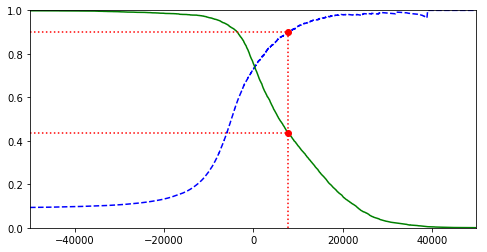

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
"""
Finally, you can plot precision and recall as functions of the threshold value using Matplotlib
"""
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.axis([-50000, 50000, 0, 1])   
    
plt.figure(figsize=(8, 4))                      # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([7813, 7813], [0., 0.9], "r:")         # Not shown
plt.plot([-50000, 7813], [0.9, 0.9], "r:")      # Not shown
plt.plot([-50000, 7813], [0.4368, 0.4368], "r:")# Not shown
plt.plot([7813], [0.9], "ro")                   # Not shown
plt.plot([7813], [0.4368], "ro")                # Not shown
plt.show()

You may wonder why the precision curve is bumpier than the recall curve. The reason is that precision may sometimes go down when you raise the threshold (although in general it will go up). On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth.

Another way to select good precision/recall tradeoff is to plot precision directly against recall.

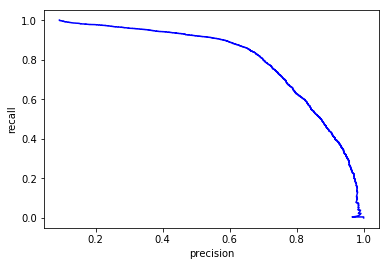

In [19]:
plt.plot(precisions[:-1], recalls[:-1], "b-")
plt.xlabel("precision")
plt.ylabel("recall")
plt.show()

We can see that precision drops sharply after recall reaches 80%. You will probably want to select a precision/recall tradeoff just before that drop -- for example, at around 60% recall. But of course the choice depends on the dataset/problem.

So let's suppose you decide to aim for 90% precision. You look up at the plot and find that you need to use a threshold of about 8000. To be more precise you can search for the lowest threshold that gives you at least 90% precision (np.argmax() will give us the first index of the maximum value, which in this case means the first True value):

In [20]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
# To make predictions (on the training set for now), instead of calling the 
# classifier's predict() method, you can just run this code:
y_train_pred_90 = (y_scores >= threshold_90_precision)
# let's check these predictions' precision and recall:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000380083618396
0.4368197749492714


Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you're done.
But not so fast: a high-precision classifier is not very useful if its recall is too low!

### The ROC Curve

The *receiver operating characteristic* (ROC) curve is another common tool used with binary classifiers. It  is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the *true positive rate* (another name for recall) against the *false positive rate*. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*. Hence the ROC curve plots *sensitivity* (recall) against 1 - *specificity*.

To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the roc_curve() function:

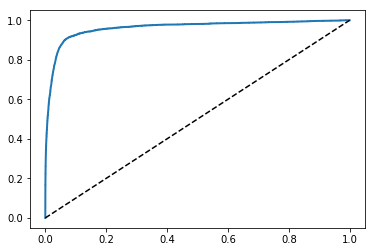

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
# Then you can plot the FPR against the TPR using Matplolib:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], "k--") # dashed diagonal
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away frm that line as possible (towards the top-left corner).

One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random clasifier will ahve a ROC AUC equal to 0.5.

Scikit-Learn provides a function to compute the ROC AUC:

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9611778893101814

Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise.

FOr example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In constrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be close to the top-right corner).

Let's train a RandomForestClassifier and compare its ROC AUC score to the SGDClassifier.

First, you need to get scores for each instance in the training set. But due to the way it works, the RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other.

The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class.

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, 
                                    method = "predict_proba")

but to plot a ROC curve, you need scores, not probabilities. 
A simple solution is to use the positive class's probability as the score:

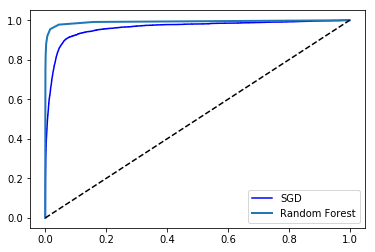

In [24]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class (second column)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
# now we are ready to plot the ROC curve. It is useful to plot the first ROC curve as well to see how they compare
plt.plot(fpr, tpr, "b", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

As you can see, the RandomForestClassier's ROC curve looks much better than the SGDClassifier's: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better:

In [25]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

Try measuring the precision and recall scores: you should find 99% precision and 86.6% recall. Not too bad!

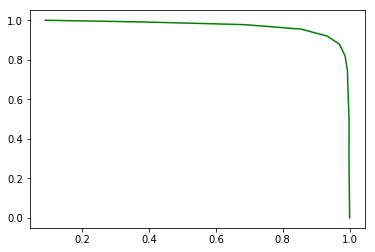

0.986046511627907
0.8212506917542889


In [26]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)
plt.plot(precisions, recalls, "g-")
plt.show()
th = thresholds[np.argmax(precisions >= 0.98)]
y_train_pred_forest = (y_scores_forest >= th)
# let's check these predictions' precision and recall:
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

Hopefully you now know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall tradeoff that fits your needs, and compare various model using ROC curves and ROC AUC scores.

### Multiclass Classification

Whereas binary classifiers distinguish betwee two classes, *multiclass classifiers* (also called *multinomial classifiers*) can distinguish between more than two classes.

Some algorithms (such as Random Forest and naive Bayes classifiers) are capable of handling multiple classes directly. Others, (such as SVMs or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

For example, one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, ..., a 9-detector). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called *one-versus-all* (OvA) strategy (also called *one-versus-the-rest*).

Another strategy is to train a binary classifier for every pair of digits: 1vs0, 2vs0, 1vs2, etc.
This is called the the *one-versus-one* (OvO) strategy. If there are N classes, you need to train N x (N - 1)/2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trainied on the part of the training set for the two classes that it must distinguish.

Some algos (such as SVMs) scale poorly with the size of the trainng set, so for these algos OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algos however, OvA is preferred.

Scikit-Learn detects when you try to use a binary classifiaction algo for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO). Let's try this with the SGDClassifier:

In [27]:
%time sgd_clf.fit(X_train, y_train) # using y_train instead of y_train_5
print(sgd_clf.predict([some_digit]))

Wall time: 2min
[5]


This code trains the SGDClassifier on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus all target classes (y_train_5). Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

To see that this is indeed the case, you can call the decision_function() method. Instead of returning just one score per instance, it now returns 10 scores, one per class:

In [28]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
# the highest score is indeed the one corresponding to class 5:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[5])

[[-15955.22627845 -38080.96296175 -13326.66694897    573.52692379
  -17680.6846644    2412.53175101 -25526.86498156 -12290.15704709
   -7946.05205023 -10631.35888549]]
5
[0 1 2 3 4 5 6 7 8 9]
5


When a classifier is trained, it stores the list of target classes in its classes_attribute, ordered by value. In this case, the index of each class in the classes_ array conveniently matches the class itself but in general you won't be so lucky.

If you want to force ScikitLearn to use OvO or OvA, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a binary classifier to its constructor. For example, this code creates a multiclass classifier using the OvO strategy, based on a SGDClassifier

In [29]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
%time ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

Wall time: 24.7 s
[5]
45


Training a RandomForestClassifier is just as easy:

In [30]:
%time forest_clf.fit(X_train, y_train)
print(forest_clf.predict([some_digit]))

Wall time: 4.32 s
[5]


This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes. You can call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class:

In [31]:
print(forest_clf.predict_proba([some_digit]))

[[0.  0.  0.  0.2 0.  0.8 0.  0.  0.  0. ]]


You can see that the classifier is fairly consident about its prediction: the 0.8 at the 5th index in the array means that the model estimates a 90% probability that the image represents a 5. It also thinks that the image could instead be a 3 with 20% probability.

Now of course you want to evaluate these classifiers. As usual, you want to use cross-validation. Let's evaluate the SGDClassifier's accuracy using the cross_val_score() function:

In [32]:
%time print(cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy"))

[0.8489802  0.87129356 0.86988048]
Wall time: 3min 25s


It gets over 84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. For example, simply scaling the inputs increases accuracy above 89%

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
%time print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy"))

[0.89707059 0.8960948  0.90693604]
Wall time: 8min 40s


### Error Analysis
Of course, if this were a real project, you would follow the steps in your Machine Learning project checklist: 

- exploring data preparation options
- trying out multiple models
- shortlisting the best ones
- fine-tuning their hyperparameters using GridSearchCV 
- automating as much as possible

Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First, you can look at the confusion matrix. You need to make predictions using hte cross_val_predict() function, then call the confusion_matrix() function, just like you did earlier

In [34]:
%time y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

Wall time: 8min 49s
[[5578    0   22    7    8   45   35    5  222    1]
 [   0 6410   35   26    4   44    4    8  198   13]
 [  28   27 5232  100   74   27   68   37  354   11]
 [  23   18  115 5254    2  209   26   38  373   73]
 [  11   14   45   12 5219   11   33   26  299  172]
 [  26   16   31  173   54 4484   76   14  482   65]
 [  31   17   45    2   42   98 5556    3  123    1]
 [  20   10   53   27   50   13    3 5696  173  220]
 [  17   64   47   91    3  125   24   11 5421   48]
 [  24   18   29   67  116   39    1  174  329 5152]]


 That's a lot of numbers. It's often more convenient to look at an image representation of the confusion matrix, using Matplotlib's mathsow() function:

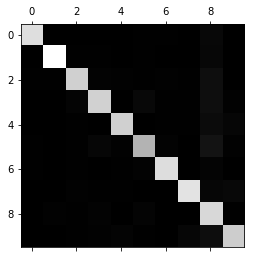

In [35]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

This confusion matrix looks fairly good, since most images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case.

Let's focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can compute error rates instead of absolute number of errors (which would make abundant classes look unfairly bad):

(10, 1)


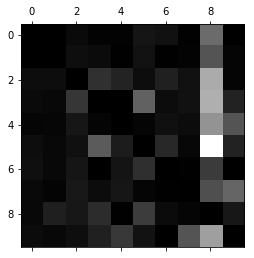

In [36]:
# each row is a class, we use keepdims to get a vector instead of a number
row_sums = conf_mx.sum(axis = 1, keepdims = True) 
print(row_sums.shape)
norm_conf_mx = conf_mx / row_sums
# now let's fill the diagonal (correct guesses) with zeros to keep only the errors and plot the results:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

Now you can clearly see the kind of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s and 5s are often confused (in both direction).

Analyzing the confusion matrix can often give you insights on ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on reducing the false 8s, For example, you could try to gather more training data for digits that look like 8s (but are not) so the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier -- for example, writing an algorithm to count the number of closed loops (8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but is more difficult and time-consuming.

For example, let's plot examples of 3s and 5s (the plot_digits() functon just uses Matplotlib's imshow() function.

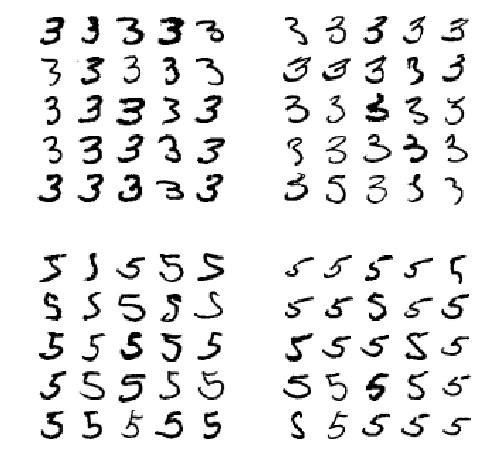

In [37]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    


cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] 
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] 
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5x5 blocks on the left show digits classified as 3s, and the two 5x5 blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong (i.e. in the bottom left and top-right blocks) are so badly written that even a human would have trouble classifying them. However, most misclassified images seem like obvious errors to us, and it's hard to understand why the classifier made the mistakes it did. 

The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion woudl be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well.


### Multilabel Classification

Until now each instanche has been assigned to just oneclass. In some cases you may want your classifier to output multiple classes for each instance. For example, consider a face-recognition classifier: what should it do if it recognizes several people on the same picture? Of course it should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning Alice yes, Bob no, Charlie yes). Such a classifiaction system that outputs multiple binary tags is called a *multilabel classification system*.

We won't go into face recognition just yet, but let's look at a simpler example, just for illustration purposes:

In [42]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
# two columns target values for each digit, one for large and one for odd
y_multilabel = np.c_[y_train_large, y_train_odd]  

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not it is odd. The next lines create a KNeighborsClassifier instance (which supports multilabel classifications, but not all classifiers do) and we train it using the multiple targets array. Now you can make a prediction, and notice that it outputs two labels:

In [43]:
print(knn_clf.predict([some_digit]))

[[False  True]]


And it predicts right, the digit 5 is indeed not large (False) and odd (True).

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. For example, one approach is to measrue the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code computes the average F1 score across all labels:

In [54]:
%time y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
print(f1_score(y_multilabel, y_train_knn_pred, average = "macro"))

Wall time: 1h 4min 21s


In [56]:
print(f1_score(y_multilabel, y_train_knn_pred, average = "macro"))

0.976410265560605


This assumes that all labels are equally important, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier's score on pictures of Alice. One simple option is to give each label a weight equal to its *support* (i.e. the number of instances with that target label). To do this, simply set average = "weighted" in the preceding code (althought there are a few other averaging options and multilabel classifier metrics).

### Multioutput Classification

The last type of classification task we are going to discuss here is called *multioutput-multiclass claclassification* (or simply *multioutput classification*). It is simply a generalization of multilabel classification where each label can be multiclass (i.e. it can have more than two possible values).

To illustrate this, let's build a system that removes noise from images. It will take as input a noisy digit image and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multiouput classification system.

**Note** The line between classification and regression is sometimes blurry, such as in this example. Arguably, predicting pixel intensity is more akin to regression than to classification. Moreover, multioutput systems are not limited to classification tasks; you could even have a system that outputs multiple labels per instance, including both class labels and value labels.

Let's start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities using NumPy's randint() function. The target images will be the original images:

In [53]:
# low, high, size (# of digits x length of feature vector) --> output is a matrix
noise = np.random.randint(0, 100, (len(X_train), 784)) 
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784)) 
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Let's plot one digit noisy image (the feature vector) and the normal image (the target vector)

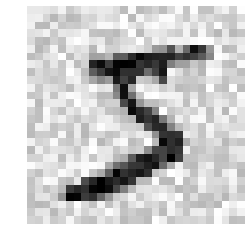

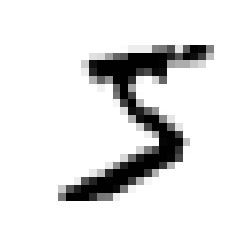

In [52]:
def plot_digit(some_digit):
    some_digit_image = some_digit.reshape(28, 28)
    plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
    plt.axis("off")
    plt.show()

plot_digit(X_train_mod[0])
plot_digit(y_train_mod[0])

Now let's train the classifier and make it clean this image:

In [ ]:
knn_clf_fit.(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test_mod[3])
plot_digit(clean_digit)

Looks close enough to the target! This concludes our tour of classification. Hopefully you should now know how to select good metrics for classification tasks, pick the appropriate precision/recall tradeoff, compare classifiers, and more generally build good classification systems for a variety of tasks.